In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

2024-01-29 11:03:02.248723: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams['figure.dpi'] = 100

## Global parameters

In [3]:
# Mock parameters
boxsize = 2000
boxcenter = 1000
nmesh = 1024
nbar = np.array([0.003, 0.012, 0.025])
cosmology = fiducial.AbacusSummitBase()
z = 0.8
bias = 1.

# Mocks
nmocks = 10

# Density smoothing parameters
cellsize = 10

In [4]:
split_model = SplitCCFModel(redshift=z, cosmology=cosmology, bias=1., nbar=0.025, smoothing_kernel=1, smoothing_scale=2*cellsize)

/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/interpolator.py:359: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = (np.asarray(xx, dtype=dtype) for xx in (x, y))


In [5]:
split_model.sigma_RR

array([0.39232093])

In [6]:
fo = Fourier(cosmology, engine='camb')
sigmaRR_th = fo.pk_interpolator(non_linear=True, of='delta_m').sigma_rz(10, z)

In [7]:
sigmaRR_th

0.4785101448203154

In [8]:
np.log(1 + sigmaRR_th)

0.39103492184946204

## $\delta_R$

In [9]:
def friedrich_lognormal_model(delta, sigma, delta0):
    pdf_model = np.zeros_like(delta)
    pdf_model[delta > -delta0] = scipy.stats.lognorm.pdf(delta[delta > -delta0], sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))
    return pdf_model

In [10]:
Nbar = np.array([(nbar[i] * 4/3 * np.pi * cellsize**3) for i in range(len(nbar))])

In [11]:
Nbar

array([ 12.56637061,  50.26548246, 104.71975512])

In [12]:
N_cic = [np.load('/feynman/work/dphp/mp270220/outputs/'+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar{:.3f}_density_cic_R{}Mpc.npy'.format(nbar[i], cellsize)) for i in range(len(nbar))]
delta_cic = [np.load('/feynman/work/dphp/mp270220/outputs/'+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar{:.3f}_density_contrast_cic_R{}Mpc.npy'.format(nbar[i], cellsize)) for i in range(len(nbar))]

In [13]:
def shot_noise_model(N, Nbar, delta0, sigma):
    delta = np.linspace(-1, 11, 100)
    pdf_deltag = friedrich_lognormal_model(delta, sigma, delta0)
    shotnoise = np.exp(N * np.log((Nbar * (1 + delta)))) / scipy.special.gamma(N+1) * np.exp(-Nbar * (1 + delta))
    pdf_N = np.trapz(pdf_deltag * shotnoise, delta)
    return pdf_N

In [14]:
def model(delta0, sigma):
    delta = np.linspace(-delta0, 11, 100)
    pdf_deltag = friedrich_lognormal_model(delta, sigma, delta0)
    return pdf_deltag

In [15]:
sigma_measured = np.log(1 + sigmaRR_th) #np.log(1 + 0.45821678868133475) #np.log(1 + np.sqrt(np.var(delta_cic[len(nbar)-1])))

In [16]:
sigma_measured

0.39103492184946204

In [17]:
delta0 = 1.1

In [18]:
N = np.arange(200)

pdf_N = [np.array([shot_noise_model(Ni, Nbar[i], delta0, sigma_measured) for Ni in N]) for i in range(len(nbar))]
pdf_N_no_shotnoise = [model(delta0, sigma_measured) for i in range(len(nbar))]

/tmp/ipykernel_1646887/2968818902.py:4: RuntimeWarning: divide by zero encountered in log
  shotnoise = np.exp(N * np.log((Nbar * (1 + delta)))) / scipy.special.gamma(N+1) * np.exp(-Nbar * (1 + delta))
/tmp/ipykernel_1646887/2968818902.py:4: RuntimeWarning: invalid value encountered in multiply
  shotnoise = np.exp(N * np.log((Nbar * (1 + delta)))) / scipy.special.gamma(N+1) * np.exp(-Nbar * (1 + delta))
/tmp/ipykernel_1646887/2968818902.py:4: RuntimeWarning: overflow encountered in exp
  shotnoise = np.exp(N * np.log((Nbar * (1 + delta)))) / scipy.special.gamma(N+1) * np.exp(-Nbar * (1 + delta))
/tmp/ipykernel_1646887/2968818902.py:4: RuntimeWarning: invalid value encountered in divide
  shotnoise = np.exp(N * np.log((Nbar * (1 + delta)))) / scipy.special.gamma(N+1) * np.exp(-Nbar * (1 + delta))


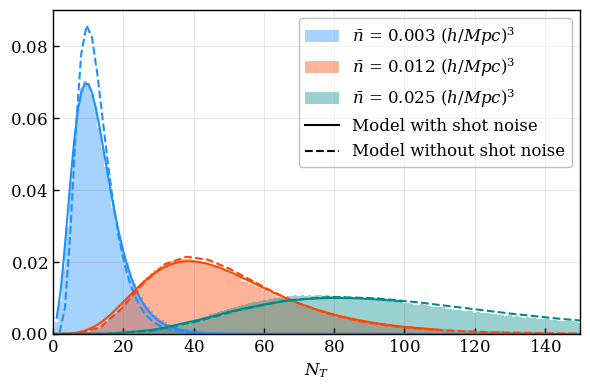

In [19]:
delta = np.linspace(-delta0, 11, 100)

colors=['dodgerblue', 'orangered', 'darkcyan']

for i in range(len(nbar)):
    bins = (np.unique(np.ravel(N_cic[i]))[1:] + np.unique(np.ravel(N_cic[i]))[:-1]) / 2
    plt.hist(np.ravel(N_cic[i]), density=True, bins=bins, alpha=0.4, label=r'$\bar{{n}}$ = {} $(h/Mpc)^3$'.format(nbar[i]), color=colors[i])
    plt.plot(pdf_N[i], color=colors[i])
    plt.plot(Nbar[i] * (1+delta), pdf_N_no_shotnoise[i]/Nbar[i], color=colors[i], ls='--')
plt.plot([], [], color='black', ls='-', label='Model with shot noise')
plt.plot([], [], color='black', ls='--', label='Model without shot noise')
plt.xlabel(r'$N_T$')
plt.legend()
plt.xlim((0, 150))
plt.savefig('shotNoiseModel_vs_Abacus_particles_cic.pdf', dpi=500)
plt.show()

In [20]:
abacus_mock = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z0.800.npy')

/tmp/ipykernel_1646887/2968818902.py:4: RuntimeWarning: divide by zero encountered in log
  shotnoise = np.exp(N * np.log((Nbar * (1 + delta)))) / scipy.special.gamma(N+1) * np.exp(-Nbar * (1 + delta))
/tmp/ipykernel_1646887/2968818902.py:4: RuntimeWarning: invalid value encountered in multiply
  shotnoise = np.exp(N * np.log((Nbar * (1 + delta)))) / scipy.special.gamma(N+1) * np.exp(-Nbar * (1 + delta))
/tmp/ipykernel_1646887/2968818902.py:4: RuntimeWarning: overflow encountered in exp
  shotnoise = np.exp(N * np.log((Nbar * (1 + delta)))) / scipy.special.gamma(N+1) * np.exp(-Nbar * (1 + delta))
/tmp/ipykernel_1646887/2968818902.py:4: RuntimeWarning: invalid value encountered in divide
  shotnoise = np.exp(N * np.log((Nbar * (1 + delta)))) / scipy.special.gamma(N+1) * np.exp(-Nbar * (1 + delta))


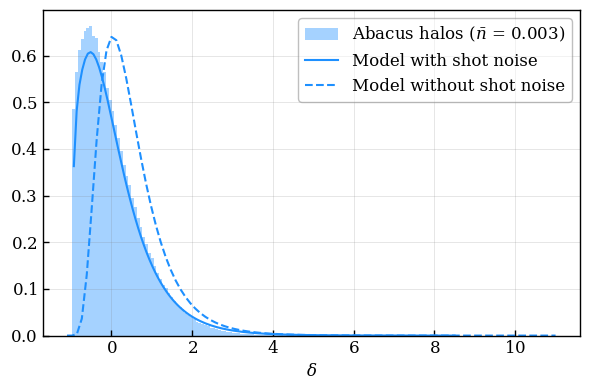

In [21]:
nbar = abacus_mock.size / abacus_mock.boxsize**3
bias = 1.5
delta0 = bias * 1.1
Nbar = nbar * 4/3 * np.pi * cellsize**3
sigma_m = np.sqrt(np.log(1 - bias + bias * np.exp(sigma_measured**2)))
N_cic = np.load('/feynman/work/dphp/mp270220/outputs/'+'AbacusSummit_2Gpc_z0.800_density_cic_R{}Mpc.npy'.format(cellsize))
delta_cic = np.load('/feynman/work/dphp/mp270220/outputs/'+'AbacusSummit_2Gpc_z0.800_density_contrast_cic_R{}Mpc.npy'.format(cellsize))
N = np.arange(400)
pdf_N = np.array([shot_noise_model(Ni, Nbar, delta0, sigma_m) for Ni in N])
pdf_N_no_shotnoise = model(delta0, sigma_m)
                 
bins = (np.unique(np.ravel(delta_cic))[1:] + np.unique(np.ravel(delta_cic))[:-1]) / 2
plt.hist(np.ravel(delta_cic), density=True, bins=bins, alpha=0.4, label=r'Abacus halos ($\bar{{n}}$ = {:.3f})'.format(nbar), color='dodgerblue')
#plt.plot(pdf_N, label=r'Model with shot noise', color='dodgerblue')
#plt.plot(Nbar * (1+delta), pdf_N_no_shotnoise/Nbar, label=r'Model without shot noise', color='dodgerblue', ls='--')
plt.plot(N/Nbar - 1, pdf_N*Nbar, label=r'Model with shot noise', color='dodgerblue')
plt.plot(delta, pdf_N_no_shotnoise, label=r'Model without shot noise', color='dodgerblue', ls='--')
#plt.xlabel(r'$N_T$')
plt.xlabel(r'$\delta$')
plt.legend()
#plt.xlim((-1, 10))
#plt.ylim((1e-6, 1))
#plt.yscale('log')
plt.savefig('shotNoiseModel_vs_Abacus_halos_cic.pdf', dpi=500)
plt.show()

[003763.50]  04-27 17:47  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z0.800_nocut_2PCF.npy.
[003763.51]  04-27 17:47  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/correlation_functions/AbacusSummit_2Gpc_z0.800_downsampled_particles_2PCF.npy.


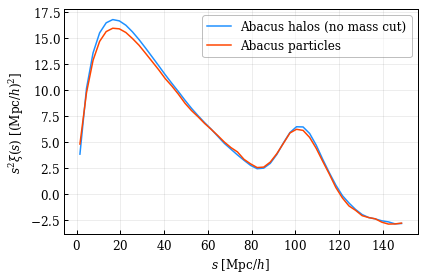

In [53]:
output_dir = '/feynman/work/dphp/mp270220/data/'

ells = [0]
nells = len(ells)

from pycorr import TwoPointCorrelationFunction

# Abacus 2PCF
xi_abacus = TwoPointCorrelationFunction.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z0.800_nocut_2PCF.npy')
xi_particles = TwoPointCorrelationFunction.load('/feynman/work/dphp/mp270220/outputs/correlation_functions/AbacusSummit_2Gpc_z0.800_downsampled_particles_2PCF.npy')
sep, xi_ells_abacus = xi_abacus.get_corr(ells=ells, return_sep=True)
sep, xi_ells_particles = xi_particles.get_corr(ells=ells, return_sep=True)

plt.rcParams["figure.figsize"] = (6, 4)

for ill, ell in enumerate(ells):
    plt.plot(sep, sep**2 * xi_ells_abacus[ill], label='Abacus halos (no mass cut)')
    plt.plot(sep, sep**2 * xi_ells_particles[ill], label='Abacus particles')

plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.savefig('Abacus_halos_vs_particles_nocut_2PCF.pdf', dpi=500)
plt.show()